# xG Modeling | Lucas Kimball | Oct 2023 | Phase 3 Project | Flatiron School

# What are Expected Goals (xG)?

Expected Goals (xG) is a statistical metric used in soccer (football) to quantify the quality and likelihood of a scoring opportunity during a match. It's a way to assess the probability that a shot will result in a goal based on various factors and historical data.

Here's a breakdown of how xG is calculated and what it represents:

1. **Shot Characteristics**: xG takes into account various parameters of a shot, including:
   - Distance from the goal
   - Angle of the shot
   - Type of play (e.g., open play, set piece, counterattack)
   - bodypart used to shoot

2. **Historical Data**: Analysts and data scientists use large datasets from past matches to analyze how likely shots with similar characteristics were to result in goals.

3. **Probability Assignment**: For each shot, a probability of it resulting in a goal is assigned based on the historical data. This probability ranges from 0 to 1, where a value approaching 0 means the shot is unlikely to be a goal and a value approaching 1 means it's highly likely.

xG is a valuable tool for coaches, analysts, and fans to analyze a team's performance, beyond just looking at the scoreline. It helps in identifying how well a team created and converted scoring opportunities during a match or across a series of matches, and it's often used for tactical analysis and scouting.

# Business Problem

The Premier League Football team AFC Richmond has hired consulting data scientists to analyze their past season in which they barely avoided relegation. Using historical data, the data scientists are tasked with providing insights that will improve tactics, information on the strength of AFC Richmonds attack and defense, and advice to their player recruitment team.

# Data Sources

The data used is from Statsbomb's open-data repository on GitHub. It includes thousands of games from dozens of competitions.

The data is provided as JSON files exported from the StatsBomb Data API, in the following structure:

- Competition and seasons stored in competitions.json.
- Matches for each competition and season, stored in matches. Each folder within is named for a competition ID, each file is named for a season ID within that competition.
- Events and lineups for each match, stored in events and lineups respectively. Each file is named for a match ID.
- StatsBomb 360 data for selected matches, stored in three-sixty. Each file is named for a match ID.

The 360 data is the sample that was used for this project, as real-time event data is needed to plot each individual shot. 

# Importing relevant packages

In [85]:
# Import necessary packages and suppress warnings

import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
import warnings
import gzip
import json
import os
import time
import math

#Soccer specific packages
from statsbombpy import sb
from mplsoccer import Pitch
from mplsoccer import VerticalPitch

#modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from imblearn.over_sampling import SMOTE
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Extracting and Merging Data

In [86]:
start_time = time.time()

def concatenate_json_files(directory_path):
    concatenated_data = []

    if not os.path.exists(directory_path):
        raise FileNotFoundError("The specified directory does not exist.")

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            file_path = os.path.join(directory_path, filename)

            try:
                # Read and parse the JSON data
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    if isinstance(json_data, list):
                        concatenated_data.extend(json_data)
                    else:
                        print(f"JSON data in file {filename} is not a list.")
            except json.JSONDecodeError as e:
                print(f"Failed to decode JSON in file {filename}: {str(e)}")
                continue  # Skip this file and continue with the next one

    return concatenated_data

# Specify the directory containing the JSON files
directory_path = "/Users/lkimball/Desktop/Flatiron/Phase3_Project/open-data/data/three-sixty"

# Concatenate the JSON files
concatenated_data = concatenate_json_files(directory_path)

end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time = end_time - start_time

print(f"The cell took {elapsed_time:.6f} seconds to run.")

Failed to decode JSON in file 3835338.json: Expecting value: line 181321 column 20 (char 5193728)
Failed to decode JSON in file 3835342.json: Expecting ',' delimiter: line 171856 column 109 (char 4882432)
Failed to decode JSON in file 3845506.json: Expecting ',' delimiter: line 92794 column 3 (char 2637824)
The cell took 197.986814 seconds to run.


In [87]:
# Convert to DataFrame
df_360 = pd.DataFrame(concatenated_data)

# Print the DataFrame
df_360.head()

,event_uuid,visible_area,freeze_frame
0,75d6cc25-b03b-44e0-9c50-99a7e3c47315,"[29.574167858721, 80.0, 47.7992071074168, 0.0,...","[{'teammate': True, 'actor': False, 'keeper': ..."
1,ec457cc8-050c-4884-abbc-1e85bc3c83dc,"[29.5261908068648, 80.0, 47.3846276547738, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
2,246b93aa-3831-4b07-a51e-b6ba578e60d5,"[27.6350829489137, 80.0, 45.4935197968227, 0.0...","[{'teammate': True, 'actor': False, 'keeper': ..."
3,eda20fee-cab0-4094-aba3-ae286ef64004,"[13.8331181325244, 80.0, 40.2628933325614, 6.1...","[{'teammate': True, 'actor': True, 'keeper': F..."
4,e8a3f021-76da-443b-9a1d-c5857c486493,"[13.8331181325244, 80.0, 40.2628933325614, 6.1...","[{'teammate': True, 'actor': True, 'keeper': F..."


In [88]:
#read in competitions data
with open('/Users/lkimball/Desktop/Flatiron/Phase3_Project/open-data/data/competitions.json', 'r') as file:
    data = json.load(file)

In [89]:
#view data
df_comp = pd.DataFrame(data)
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             67 non-null     int64 
 1   season_id                  67 non-null     int64 
 2   country_name               67 non-null     object
 3   competition_name           67 non-null     object
 4   competition_gender         67 non-null     object
 5   competition_youth          67 non-null     bool  
 6   competition_international  67 non-null     bool  
 7   season_name                67 non-null     object
 8   match_updated              67 non-null     object
 9   match_updated_360          51 non-null     object
 10  match_available_360        5 non-null      object
 11  match_available            67 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 5.5+ KB


As we can see above, there are only 5 competitions that contain the 360 event data we are looking for. Of those 5, 3 were men's competitions and 2 were women's. In the interest of having as many data points as possible while not adding another factor into the dataset, only the 3 men's competitons were used. 

In [90]:
# Create a new DataFrame with only non-null records in 'match_available_360'
df_comp_360 = df_comp.dropna(subset=['match_available_360'])

# Display the new DataFrame
df_comp_360

#dropping female competitions
df_comp_360 = df_comp_360[df_comp_360['competition_gender'] != 'female']
df_comp_360

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
26,43,106,International,FIFA World Cup,male,False,True,2022,2023-08-12T16:44:27.619465,2023-08-17T15:55:15.164685,2023-08-17T15:55:15.164685,2023-08-12T16:44:27.619465
35,11,90,Spain,La Liga,male,False,False,2020/2021,2023-07-26T14:11:01.312143,2023-07-26T14:15:15.217027,2023-07-26T14:15:15.217027,2023-07-26T14:11:01.312143
62,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979


In [91]:
df_2022WC = sb.matches(competition_id=43, season_id=106)
df_2022WC.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,...,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,...,2023-07-11T14:56:31.096588,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
4,3857288,2022-11-26,12:00:00.000,International - FIFA World Cup,2022,Tunisia,Australia,0,1,available,...,2023-04-27T00:30:07.835815,2,Group Stage,Al Janoub Stadium,Daniel Siebert,Jalel Kadri,Graham James Arnold,1.1.0,2,2


In [92]:
#Getting the event data for all matches in the 2022 WC
start_time = time.time()


# Assuming df_2022WC is your DataFrame containing match_id column
match_ids = df_2022WC['match_id'].tolist()

# Create an empty list to store DataFrames for each match
all_events = []

# Iterate through match IDs and retrieve events
for match_id in match_ids:
    events_df = sb.events(match_id=match_id)
    all_events.append(events_df)

# Concatenate all DataFrames into one
combined_events_df = pd.concat(all_events, ignore_index=True)


end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time = end_time - start_time

print(f"The cell took {elapsed_time:.6f} seconds to run.")

The cell took 103.344032 seconds to run.


In [93]:
#sanity check
combined_events_df.columns

Index(['bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot',
       ...
       'shot_follows_dribble', 'block_save_block',
       'goalkeeper_shot_saved_to_post', 'shot_saved_to_post',
       'half_start_late_video_start', 'goalkeeper_shot_saved_off_target',
       'shot_saved_off_target', 'goalkeeper_success_in_play', 'shot_redirect',
       'goalkeeper_lost_in_play'],
      dtype='object', length=110)

# Data Cleaning

As our model is based on predicting goals, we only wanted the events that were labeled as shots.

In [94]:
#check the breakdown of events
combined_events_df['type'].value_counts()

Pass                 68515
Ball Receipt*        63715
Carry                53764
Pressure             16553
Ball Recovery         5821
Duel                  4389
Clearance             2684
Block                 2386
Dribble               1793
Goal Keeper           1790
Foul Committed        1775
Miscontrol            1755
Foul Won              1693
Shot                  1494
Dispossessed          1431
Interception          1371
Dribbled Past         1036
Substitution           587
Injury Stoppage        403
Half Start             286
Half End               286
Tactical Shift         243
50/50                  236
Referee Ball-Drop      162
Starting XI            128
Shield                 104
Player Off              74
Player On               74
Bad Behaviour           44
Error                   28
Offside                 26
Own Goal Against         3
Own Goal For             3
Name: type, dtype: int64

In [95]:
#isolating shots
combined_events_df = combined_events_df[combined_events_df['type'] == 'Shot']
combined_events_df.head()

,bad_behaviour_card,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,shot_follows_dribble,block_save_block,goalkeeper_shot_saved_to_post,shot_saved_to_post,half_start_late_video_start,goalkeeper_shot_saved_off_target,shot_saved_off_target,goalkeeper_success_in_play,shot_redirect,goalkeeper_lost_in_play
2674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, because our model is focused on shots, and the features that influence their outcome, any columns related to other 'events' should be dropped.

In [96]:
#make list of columns unrelated to shots
columns_to_drop = ['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_offensive', 'ball_recovery_recovery_failure',
       'block_deflection', 'block_offensive', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_other', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun',
       'duel_outcome', 'duel_type', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_penalty', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'foul_won_penalty', 'goalkeeper_body_part',
       'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_technique', 'goalkeeper_type',
       'interception_outcome', 'off_camera', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length',
       'pass_outcome', 'pass_outswinging', 'pass_recipient',
       'pass_shot_assist', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'possession',
       'possession_team', 'possession_team_id', 'related_events', 'second',
       'substitution_outcome', 'substitution_replacement', 'tactics','under_pressure','period', 'visible_area', 'timestamp',
        'shot_key_pass_id','shot_aerial_won','position', 'out',  'team', 'player', 'injury_stoppage_in_chain','pass_miscommunication',
        'miscontrol_aerial_won', 'pass_no_touch', 'pass_straight',
       'dribble_no_touch', 'goalkeeper_punched_out','block_save_block', 'goalkeeper_shot_saved_to_post',
       'shot_saved_to_post', 'half_start_late_video_start',
       'goalkeeper_shot_saved_off_target', 'duration', 'goalkeeper_lost_in_play', 'goalkeeper_success_in_play','shot_redirect', 'type', 
                  'player_off_permanent', 'goalkeeper_penalty_saved_to_post', 'shot_saved_off_target', 'pass_cut_back']

In [97]:
#dropping unwanted columns
columns_to_drop_existing = [col for col in columns_to_drop if col in combined_events_df.columns]
combined_events_df.drop(columns=columns_to_drop_existing, inplace=True, errors='ignore')

In [98]:
#sanity check on remaining columns
combined_events_df.columns

Index(['goalkeeper_position', 'id', 'index', 'location', 'match_id', 'minute',
       'play_pattern', 'player_id', 'shot_body_part', 'shot_deflected',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_one_on_one', 'shot_open_goal', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type',
       'shot_follows_dribble'],
      dtype='object')

In [99]:
#labeling as WC specific data
WCevents = combined_events_df

In [100]:
df_comp_360

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
26,43,106,International,FIFA World Cup,male,False,True,2022,2023-08-12T16:44:27.619465,2023-08-17T15:55:15.164685,2023-08-17T15:55:15.164685,2023-08-12T16:44:27.619465
35,11,90,Spain,La Liga,male,False,False,2020/2021,2023-07-26T14:11:01.312143,2023-07-26T14:15:15.217027,2023-07-26T14:15:15.217027,2023-07-26T14:11:01.312143
62,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979


In [101]:
#isolating matches for La liga 2020/2021
df_LL = sb.matches(competition_id=11, season_id=90)
df_LL.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3773386,2020-10-31,21:00:00.000,Spain - La Liga,2020/2021,Deportivo Alavés,Barcelona,1,1,available,...,2023-07-25T04:25:41.348202,8,Regular Season,Estadio de Mendizorroza,NaN,Pablo Javier Machín Díez,Ronald Koeman,1.1.0,2,2
1,3773565,2021-01-09,18:30:00.000,Spain - La Liga,2020/2021,Granada,Barcelona,0,4,available,...,2023-07-25T04:30:16.058384,18,Regular Season,Estadio Nuevo Los Cármenes,Ricardo De Burgos Bengoetxea,Diego Martínez Penas,Ronald Koeman,1.1.0,2,2
2,3773457,2021-05-16,18:30:00.000,Spain - La Liga,2020/2021,Barcelona,Celta Vigo,1,2,available,...,2023-04-27T23:03:53.506485,37,Regular Season,Spotify Camp Nou,NaN,Ronald Koeman,Eduardo Germán Coudet,1.1.0,2,2
3,3773631,2021-02-07,21:00:00.000,Spain - La Liga,2020/2021,Real Betis,Barcelona,2,3,available,...,2023-07-25T03:56:34.733180,22,Regular Season,Estadio Benito Villamarín,NaN,Manuel Luis Pellegrini Ripamonti,Ronald Koeman,1.1.0,2,2
4,3773665,2021-03-06,21:00:00.000,Spain - La Liga,2020/2021,Osasuna,Barcelona,0,2,available,...,2023-04-28T02:57:03.412841,26,Regular Season,Estadio El Sadar,Guillermo Cuadra Fernández,Jagoba Arrasate Elustondo,Ronald Koeman,1.1.0,2,2


In [102]:
##Getting the event data for all matches in the 2020/2021 la liga season
start_time = time.time()


# Assuming df_2022WC is your DataFrame containing match_id column
match_ids = df_LL['match_id'].tolist()

# Create an empty list to store DataFrames for each match
all_events = []

# Iterate through match IDs and retrieve events
for match_id in match_ids:
    events_df = sb.events(match_id=match_id)
    all_events.append(events_df)

# Concatenate all DataFrames into one
combined_events_df = pd.concat(all_events, ignore_index=True)


end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time = end_time - start_time

print(f"The cell took {elapsed_time:.6f} seconds to run.")

The cell took 57.895756 seconds to run.


In [103]:
#isolating shots
combined_events_df = combined_events_df[combined_events_df['type'] == 'Shot']
combined_events_df

,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,foul_won_penalty,goalkeeper_punched_out,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,block_save_block,dribble_no_touch,shot_redirect,shot_follows_dribble
3805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
#dropping unwanted columns
columns_to_drop_existing = [col for col in columns_to_drop if col in combined_events_df.columns]
combined_events_df.drop(columns=columns_to_drop_existing, inplace=True, errors='ignore')

In [105]:
LaLiga_events = combined_events_df

In [106]:
LaLiga_events.head()

,goalkeeper_position,id,index,location,match_id,minute,play_pattern,player_id,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_one_on_one,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,shot_deflected,shot_follows_dribble
3805,NaN,c5341577-e1ca-4742-98fb-dc745cbbe103,575,"[108.6, 28.0]",3773386,12,From Throw In,30756.0,Right Foot,"[120.0, 47.8, 0.0]",NaN,"[{'location': [91.6, 30.4], 'player': {'id': 5...",True,NaN,Off T,0.200969,Normal,Open Play,NaN,NaN
3806,NaN,1aedaf9e-bc12-4d0a-953d-bd0f7db3688a,681,"[103.6, 51.0]",3773386,16,Regular Play,26387.0,Right Foot,"[115.8, 42.1, 0.0]",True,"[{'location': [97.2, 35.3], 'player': {'id': 2...",NaN,NaN,Saved,0.096384,Normal,Open Play,NaN,NaN
3807,NaN,96b28bfc-d174-4b38-86cf-5a43cda4a14f,901,"[104.3, 33.9]",3773386,19,From Throw In,5487.0,Left Foot,"[120.0, 50.6, 0.0]",True,"[{'location': [104.3, 36.7], 'player': {'id': ...",NaN,NaN,Off T,0.098879,Normal,Open Play,NaN,NaN
3808,NaN,b9ca5464-1f5a-401b-a31d-8101bd61072a,929,"[97.9, 44.3]",3773386,22,From Free Kick,5503.0,Left Foot,"[119.8, 37.6]",NaN,"[{'location': [114.1, 43.8], 'player': {'id': ...",NaN,NaN,Blocked,0.078938,Normal,Free Kick,NaN,NaN
3809,NaN,75bdc651-c041-4021-b201-cb9eb8b97837,1282,"[118.3, 42.1]",3773386,30,Regular Play,24049.0,Left Foot,"[120.0, 40.7, 0.0]",NaN,"[{'location': [108.6, 55.2], 'player': {'id': ...",True,True,Goal,0.976192,Normal,Open Play,NaN,NaN


In [107]:
#isolating matches for Euro 2020
df_Euro = sb.matches(competition_id=55, season_id=43)
df_Euro.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3795108,2021-07-02,18:00:00.000,Europe - UEFA Euro,2020,Switzerland,Spain,1,1,available,...,2023-04-27T21:55:08.695971,5,Quarter-finals,Saint-Petersburg Stadium,Michael Oliver,Vladimir Petković,Luis Enrique Martínez García,1.1.0,2,2
1,3788769,2021-06-21,21:00:00.000,Europe - UEFA Euro,2020,Russia,Denmark,1,4,available,...,2023-04-27T22:20:21.686564,3,Group Stage,Parken,Clément Turpin,Stanislav Cherchesov,Kasper Hjulmand,1.1.0,2,2
2,3788766,2021-06-20,18:00:00.000,Europe - UEFA Euro,2020,Italy,Wales,1,0,available,...,2023-04-27T22:22:42.769375,3,Group Stage,Estadio Olímpico,Ovidiu Alin Hațegan,Roberto Mancini,Robert Page,1.1.0,2,2
3,3795220,2021-07-06,21:00:00.000,Europe - UEFA Euro,2020,Italy,Spain,1,1,available,...,2022-08-04T12:00,6,Semi-finals,Wembley Stadium,Felix Brych,Roberto Mancini,Luis Enrique Martínez García,1.1.0,2,2
4,3788761,2021-06-18,15:00:00.000,Europe - UEFA Euro,2020,Sweden,Slovakia,1,0,available,...,2023-04-27T22:28:52.986485,2,Group Stage,Saint-Petersburg Stadium,Daniel Siebert,Jan Olof Andersson,Štefan Tarkovič,1.1.0,2,2


In [108]:
##Getting the event data for all matches in the 2020/2021 la liga season
start_time = time.time()


# Assuming df_2022WC is your DataFrame containing match_id column
match_ids = df_Euro['match_id'].tolist()

# Create an empty list to store DataFrames for each match
all_events = []

# Iterate through match IDs and retrieve events
for match_id in match_ids:
    events_df = sb.events(match_id=match_id)
    all_events.append(events_df)

# Concatenate all DataFrames into one
combined_events_df = pd.concat(all_events, ignore_index=True)


end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time = end_time - start_time

print(f"The cell took {elapsed_time:.6f} seconds to run.")

The cell took 87.726350 seconds to run.


In [109]:
#isolating shots
combined_events_df = combined_events_df[combined_events_df['type'] == 'Shot']
combined_events_df

,50_50,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,...,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,goalkeeper_lost_in_play,goalkeeper_success_in_play,dribble_no_touch,goalkeeper_penalty_saved_to_post,shot_follows_dribble,player_off_permanent
4670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
#dropping unwanted columns
columns_to_drop_existing = [col for col in columns_to_drop if col in combined_events_df.columns]
combined_events_df.drop(columns=columns_to_drop_existing, inplace=True, errors='ignore')

In [111]:
#assigning unique name
Euro_events = combined_events_df

In [112]:
#concatenating the dfs with 360 data together
shots_df = pd.concat([WCevents, LaLiga_events, Euro_events], ignore_index=True)

#checking column values
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3622 entries, 0 to 3621
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   goalkeeper_position   0 non-null      object 
 1   id                    3622 non-null   object 
 2   index                 3622 non-null   int64  
 3   location              3622 non-null   object 
 4   match_id              3622 non-null   int64  
 5   minute                3622 non-null   int64  
 6   play_pattern          3622 non-null   object 
 7   player_id             3622 non-null   float64
 8   shot_body_part        3622 non-null   object 
 9   shot_deflected        51 non-null     object 
 10  shot_end_location     3622 non-null   object 
 11  shot_first_time       1126 non-null   object 
 12  shot_freeze_frame     3512 non-null   object 
 13  shot_one_on_one       200 non-null    object 
 14  shot_open_goal        43 non-null     object 
 15  shot_outcome         

In [113]:
shots_df.head()

,goalkeeper_position,id,index,location,match_id,minute,play_pattern,player_id,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_one_on_one,shot_open_goal,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,shot_follows_dribble
0,NaN,61d52e72-a8ff-49c4-be02-057b1ea0fb15,20,"[96.0, 38.8]",3857256,0,From Kick Off,3500.0,Left Foot,NaN,"[108.2, 38.5]",True,"[{'location': [86.2, 51.6], 'player': {'id': 3...",NaN,NaN,Blocked,0.036566,Half Volley,Open Play,NaN
1,NaN,aa77495b-0e7b-44f0-a2eb-11605085943a,25,"[113.1, 40.7]",3857256,0,From Kick Off,5545.0,Left Foot,NaN,"[114.8, 40.6, 1.6]",True,"[{'location': [104.9, 50.6], 'player': {'id': ...",NaN,NaN,Saved,0.353289,Half Volley,Open Play,NaN
2,NaN,51026369-a4ad-4a71-b14a-6e7f8b764772,28,"[103.8, 41.9]",3857256,0,From Kick Off,3500.0,Right Foot,NaN,"[115.5, 39.1, 1.0]",True,"[{'location': [115.6, 40.2], 'player': {'id': ...",NaN,NaN,Saved,0.069527,Half Volley,Open Play,NaN
3,NaN,6ac240f5-8b84-4c06-8153-b56109c8c5e6,196,"[112.2, 36.8]",3857256,4,From Corner,5603.0,Head,NaN,"[120.0, 35.3, 3.5]",NaN,"[{'location': [113.0, 36.2], 'player': {'id': ...",NaN,NaN,Off T,0.081609,Normal,Open Play,NaN
4,NaN,00e599c0-5234-4b6a-9b91-d6f789a311b0,356,"[97.8, 51.5]",3857256,10,Regular Play,6318.0,Left Foot,NaN,"[120.0, 36.1, 0.6]",NaN,"[{'location': [100.1, 56.9], 'player': {'id': ...",NaN,NaN,Post,0.030002,Normal,Open Play,NaN


In [114]:
#changing shot_location to 2 seperate columns
shots_df[['x_start', 'y_start']] = pd.DataFrame(shots_df.location.tolist(), index=shots_df.index)

In [115]:
#changing shot_end_location to 3 seperate columns
shots_df[['x_end', 'y_end', 'c_end']] = pd.DataFrame(shots_df.shot_end_location.tolist(), index=shots_df.index)

In [116]:
#getting a sense for shots to goals ratio
shots_df['shot_outcome'].value_counts()

Off T               1120
Blocked              919
Saved                856
Goal                 461
Wayward              161
Post                  82
Saved Off Target      12
Saved to Post         11
Name: shot_outcome, dtype: int64

In [117]:
#Viewing breakdown of shot types
shots_df['shot_type'].value_counts()

Open Play    3348
Free Kick     141
Penalty       131
Corner          2
Name: shot_type, dtype: int64

Shots directly from set-pieces (ie. penalities, free kicks, corners) are different from shots from general play, and AFC Richmond is focused on how to improve in the general run of play rather than specificly on shots from set plays.

In [118]:
#dropping all penalties
shots_df.drop(shots_df[shots_df['shot_type'] == 'Penalty'].index, inplace=True)

In [119]:
#dropping all Free Kicks
shots_df.drop(shots_df[shots_df['shot_type'] == 'Free Kick'].index, inplace=True)

In [120]:
#dropping all Corners
shots_df.drop(shots_df[shots_df['shot_type'] == 'Corner'].index, inplace=True)

In [121]:
#sanity check breakdown of shot types
shots_df['shot_type'].value_counts()

Open Play    3348
Name: shot_type, dtype: int64

In [122]:
#check breakdown of shot techniques
shots_df['shot_technique'].value_counts()

Normal           2573
Half Volley       479
Volley            218
Lob                25
Diving Header      24
Backheel           16
Overhead Kick      13
Name: shot_technique, dtype: int64

In [123]:
#making a new column with binary values for goal or no goal
shots_df['goal'] = (shots_df['shot_outcome'] == 'Goal').astype(int)
shots_df['goal'].value_counts()

0    2979
1     369
Name: goal, dtype: int64

# Visualizing the Data

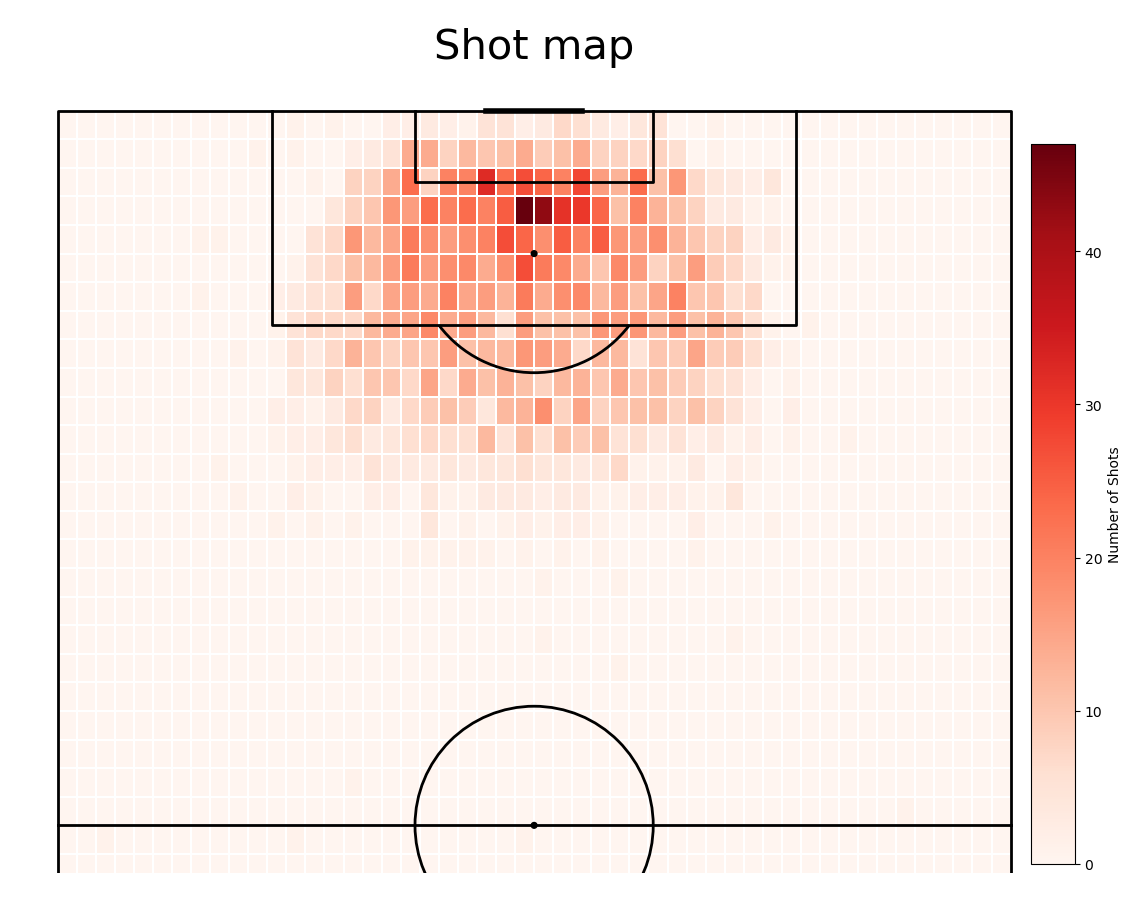

In [124]:
#plotting heatmap for shots 
pitch = VerticalPitch(line_color='black', half = True, pitch_type= 'statsbomb', line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(shots_df.x_start, shots_df.y_start, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar, label = 'Number of Shots')
fig.suptitle('Shot map' , fontsize = 30)
plt.show()

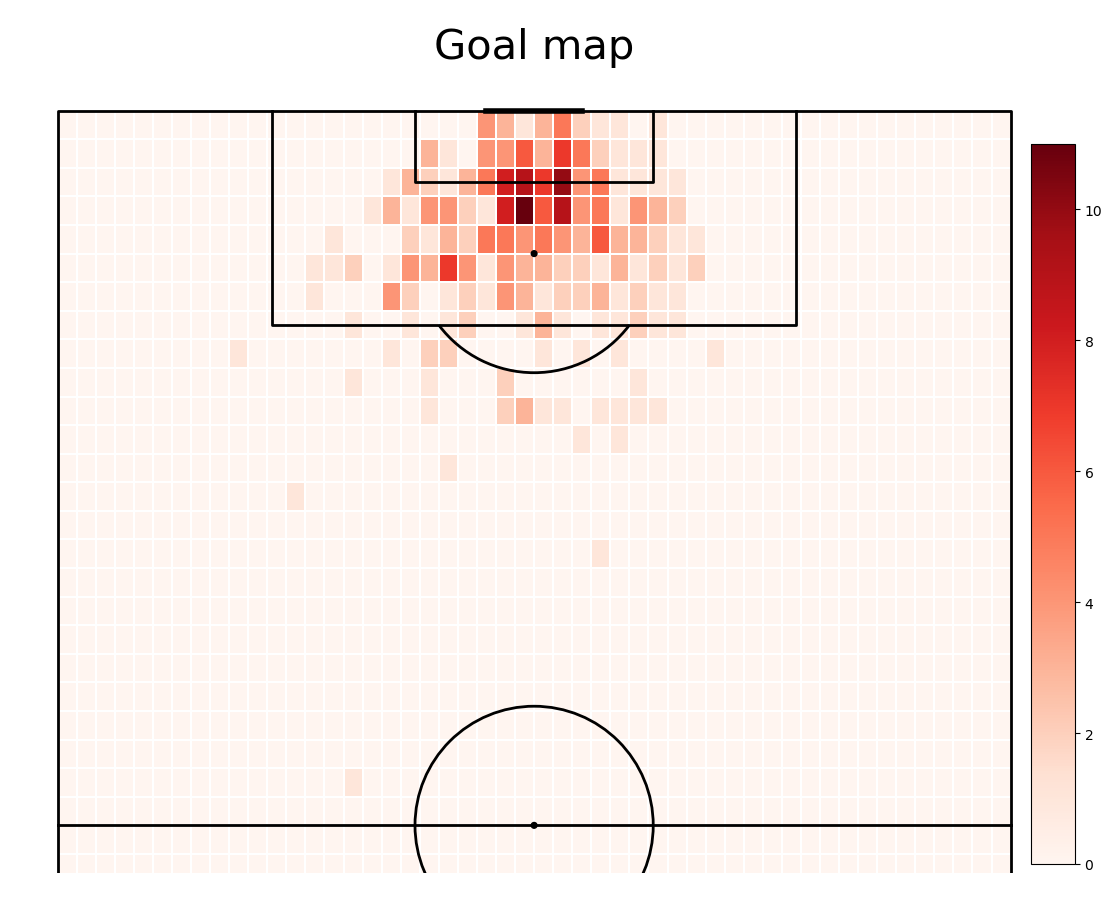

In [125]:
#take only goals
goals = shots_df[shots_df["goal"] == 1]
#plotting heatmap for shots 
pitch = VerticalPitch(line_color='black', half = True, pitch_type= 'statsbomb', line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#calculate number of shots in each bin
bin_statistic_goals = pitch.bin_statistic(goals.x_start, goals.y_start, bins=50)
#make heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map' , fontsize = 30)
plt.show()

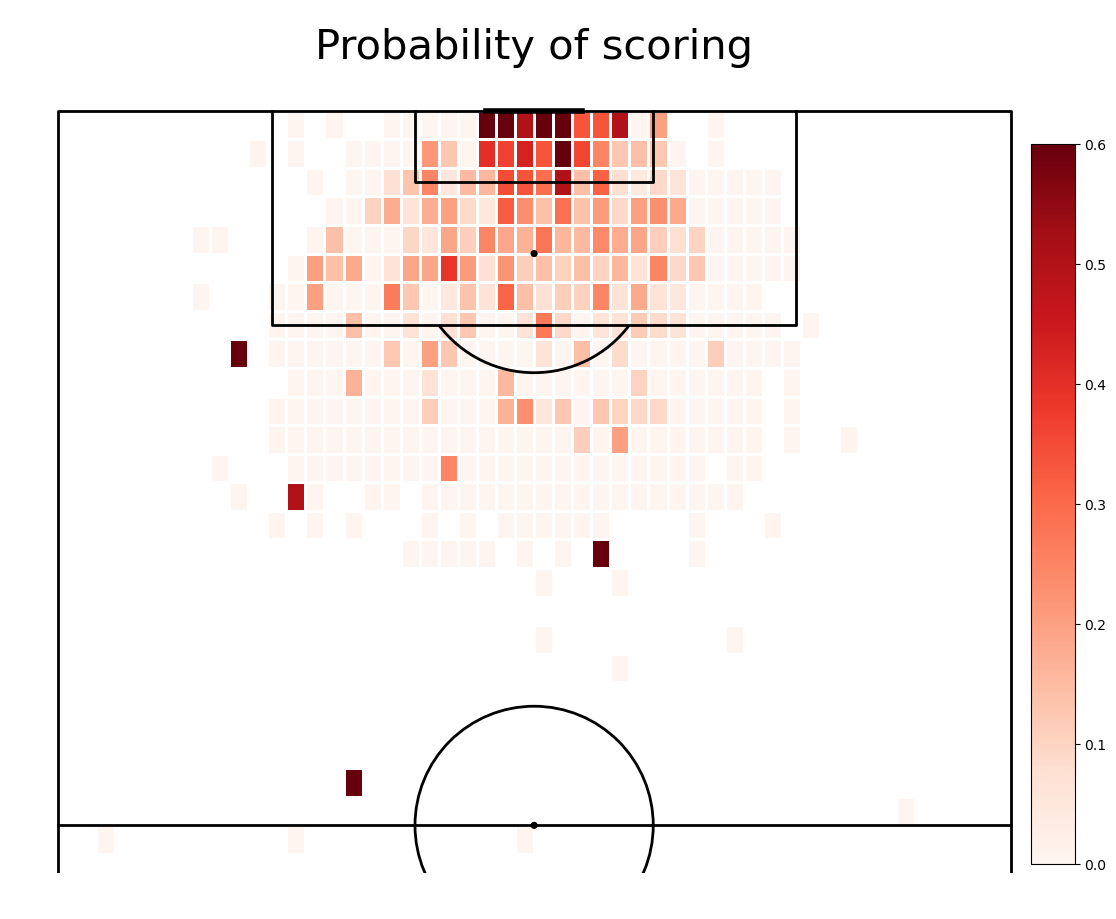

In [126]:
#plot pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='statsbomb', line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
bin_statistic = pitch.bin_statistic(shots_df.x_start, shots_df.y_start, bins=50)
#normalize number of goals by number of shots
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
#plot heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)
#make legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring' , fontsize = 30)
plt.show()



From the above heatmaps, we now have a sense for where shots are generally taken from, where goals are scored from, and which locations offer the highest probability of scoring if a shot is taken. We can also tell that in the 'Probability of Scoring' visual that there are some outliers far from goal. We can also see in the 'Shot Map' visual that there are very few shots from these locations. We are keeping these datapoints within the dataset in the hope that other features can explain why it is 'likely' that a shot would be scored from that location, while also acknowledging the rational answer that very few shots are taken from those locations and if a goal was scored from there it would articially inflate the probability of scoring within this dataset.

Statsbomb event data is set up so that the X, Y (0,0) coordinate is in the upper left of the soccer pitch if we are looking at it horizontally oriented, with a goal on the both the left and right sides. Additionally every shot is plotted as if the attacking team was shooting at the right sided goal. For the future math we must do to calculate the angle and distance of every shot, it is easier to do if the X coordinate is 0. For that reason we reflect all the shots as if they were taken on the left side instead.

In [127]:
#reflecting the values on to the left half of the pitch
shots_df['x_start'] = 120 - shots_df['x_start']

In [128]:
#sanity check
shots_df.columns

Index(['goalkeeper_position', 'id', 'index', 'location', 'match_id', 'minute',
       'play_pattern', 'player_id', 'shot_body_part', 'shot_deflected',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_one_on_one', 'shot_open_goal', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type',
       'shot_follows_dribble', 'x_start', 'y_start', 'x_end', 'y_end', 'c_end',
       'goal'],
      dtype='object')

In [129]:
#renaming columns
shots_df['x'] = shots_df['x_start']
shots_df['y'] = shots_df['y_start']

#drop old
shots_df.drop(['x_start', 'y_start'], axis=1, inplace=True)

In [130]:
#sanity check
shots_df.columns

Index(['goalkeeper_position', 'id', 'index', 'location', 'match_id', 'minute',
       'play_pattern', 'player_id', 'shot_body_part', 'shot_deflected',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_one_on_one', 'shot_open_goal', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type',
       'shot_follows_dribble', 'x_end', 'y_end', 'c_end', 'goal', 'x', 'y'],
      dtype='object')

# Calculating the Angle of shots

In [131]:
# Coordinates of the goalposts
x_A, y_A = 0, 36  # Right goalpost
x_B, y_B = 0, 44  # Left goalpost

# Shot locations
x_C = shots_df['x']
y_C = shots_df['y']

# Calculate distances of sides of the triangles 
d_AB = math.sqrt((x_B - x_A)**2 + (y_B - y_A)**2)
d_BC = ((x_C - x_B)**2 + (y_C - y_B)**2).apply(math.sqrt)
d_AC = ((x_C - x_A)**2 + (y_C - y_A)**2).apply(math.sqrt)

# Calculate the angle at point C in radians
cos_theta = (d_AC**2 + d_BC**2 - d_AB**2) / (2 * d_AC * d_BC)
theta_radians = cos_theta.apply(math.acos)

# Convert angle to degrees
theta_degrees = theta_radians.apply(math.degrees)

# Create a new column 'angle' in the DataFrame
shots_df['angle'] = theta_degrees

#DataFrame with the angle column
shots_df.head()


,goalkeeper_position,id,index,location,match_id,minute,play_pattern,player_id,shot_body_part,shot_deflected,...,shot_technique,shot_type,shot_follows_dribble,x_end,y_end,c_end,goal,x,y,angle
0,NaN,61d52e72-a8ff-49c4-be02-057b1ea0fb15,20,"[96.0, 38.8]",3857256,0,From Kick Off,3500.0,Left Foot,NaN,...,Half Volley,Open Play,NaN,108.2,38.5,NaN,0,24.0,38.8,18.879548
1,NaN,aa77495b-0e7b-44f0-a2eb-11605085943a,25,"[113.1, 40.7]",3857256,0,From Kick Off,5545.0,Left Foot,NaN,...,Half Volley,Open Play,NaN,114.8,40.6,1.6,0,6.9,40.7,59.821068
2,NaN,51026369-a4ad-4a71-b14a-6e7f8b764772,28,"[103.8, 41.9]",3857256,0,From Kick Off,3500.0,Right Foot,NaN,...,Half Volley,Open Play,NaN,115.5,39.1,1.0,0,16.2,41.9,27.397542
3,NaN,6ac240f5-8b84-4c06-8153-b56109c8c5e6,196,"[112.2, 36.8]",3857256,4,From Corner,5603.0,Head,NaN,...,Normal,Open Play,NaN,120.0,35.3,3.5,0,7.8,36.8,48.565404
4,NaN,00e599c0-5234-4b6a-9b91-d6f789a311b0,356,"[97.8, 51.5]",3857256,10,Regular Play,6318.0,Left Foot,NaN,...,Normal,Open Play,NaN,120.0,36.1,0.6,0,22.2,51.5,16.255762


# Calculating the Euclidean Distance to the goal

In [132]:
# Coordinates of point E
x_E, y_E = 0, 40  #The middle of the goal

# reminder of Shot locations
x_C = shots_df['x']
y_C = shots_df['y']

# Calculate the Euclidean distance
distance_CE = np.sqrt((x_E - x_C)**2 + (y_E - y_C)**2)

#assign the values to a new column
shots_df['distance'] = distance_CE

shots_df.head()

,goalkeeper_position,id,index,location,match_id,minute,play_pattern,player_id,shot_body_part,shot_deflected,...,shot_type,shot_follows_dribble,x_end,y_end,c_end,goal,x,y,angle,distance
0,NaN,61d52e72-a8ff-49c4-be02-057b1ea0fb15,20,"[96.0, 38.8]",3857256,0,From Kick Off,3500.0,Left Foot,NaN,...,Open Play,NaN,108.2,38.5,NaN,0,24.0,38.8,18.879548,24.029981
1,NaN,aa77495b-0e7b-44f0-a2eb-11605085943a,25,"[113.1, 40.7]",3857256,0,From Kick Off,5545.0,Left Foot,NaN,...,Open Play,NaN,114.8,40.6,1.6,0,6.9,40.7,59.821068,6.935416
2,NaN,51026369-a4ad-4a71-b14a-6e7f8b764772,28,"[103.8, 41.9]",3857256,0,From Kick Off,3500.0,Right Foot,NaN,...,Open Play,NaN,115.5,39.1,1.0,0,16.2,41.9,27.397542,16.311039
3,NaN,6ac240f5-8b84-4c06-8153-b56109c8c5e6,196,"[112.2, 36.8]",3857256,4,From Corner,5603.0,Head,NaN,...,Open Play,NaN,120.0,35.3,3.5,0,7.8,36.8,48.565404,8.430896
4,NaN,00e599c0-5234-4b6a-9b91-d6f789a311b0,356,"[97.8, 51.5]",3857256,10,Regular Play,6318.0,Left Foot,NaN,...,Open Play,NaN,120.0,36.1,0.6,0,22.2,51.5,16.255762,25.001800


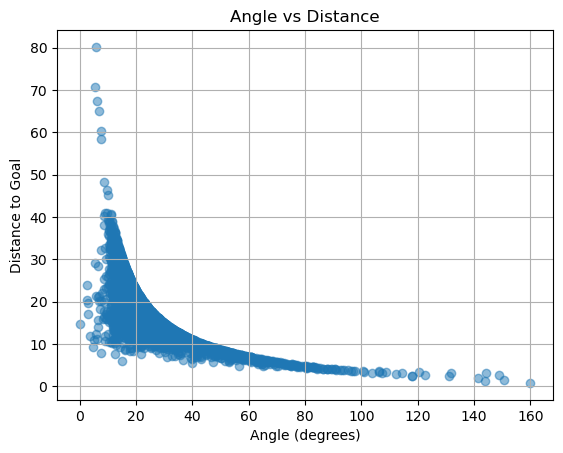

In [133]:
# Comparing Shot angle v Shot distance 

# Create a scatter plot
plt.scatter(shots_df['angle'], shots_df['distance'], alpha=0.5)
plt.xlabel('Angle (degrees)')
plt.ylabel('Distance to Goal')
plt.title('Angle vs Distance')
plt.grid(True)

# Show the plot
plt.show()


This visual comparing Angle and Distance is a sanity check for the calculations done to get angle and distance as features. We can see the barrier of physics preventing a shot from 50 meters having an angle higher than 20 degrees for example.

# Visualizing the Impact of Distance and Angle on Shots

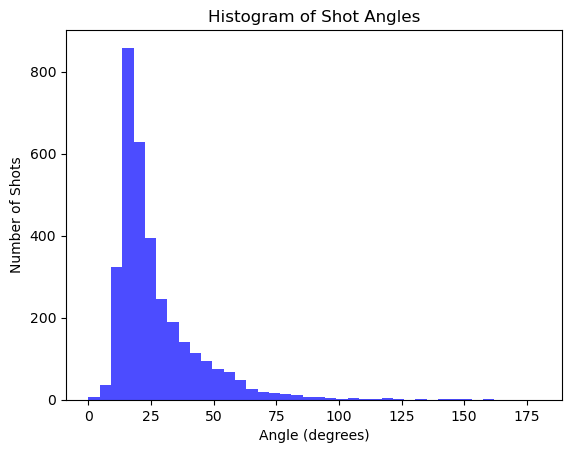

In [134]:
# Define the number of bins and the range of angles
num_bins = 40
angle_range = (0, 180)  # Range of angles (in degrees)

# Extract the 'angle' column and calculate the histogram
angles = shots_df['angle']
hist, bin_edges = np.histogram(angles, bins=num_bins, range=angle_range)

plt.hist(angles, bins=num_bins, range=angle_range, alpha=0.7, color='b')
plt.xlabel('Angle (degrees)')
plt.ylabel('Number of Shots')
plt.title('Histogram of Shot Angles')
plt.show()

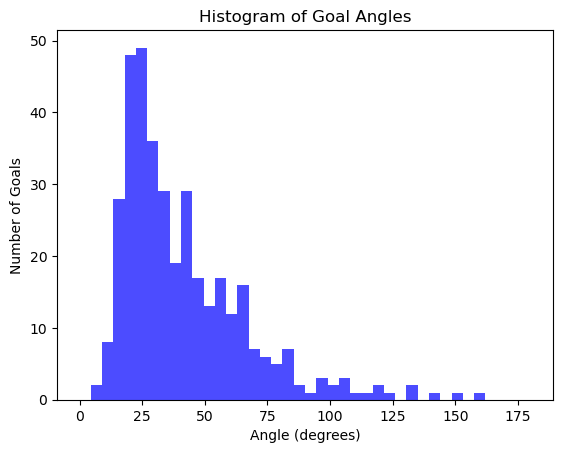

In [135]:
# Extract the 'angle' and 'goal' columns and filter by goals
angles = shots_df[shots_df['goal'] == 1]['angle']

# Calculate the histogram for goals
hist, bin_edges = np.histogram(angles, bins=num_bins, range=angle_range)

plt.hist(angles, bins=num_bins, range=angle_range, alpha=0.7, color='b')
plt.xlabel('Angle (degrees)')
plt.ylabel('Number of Goals')
plt.title('Histogram of Goal Angles')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


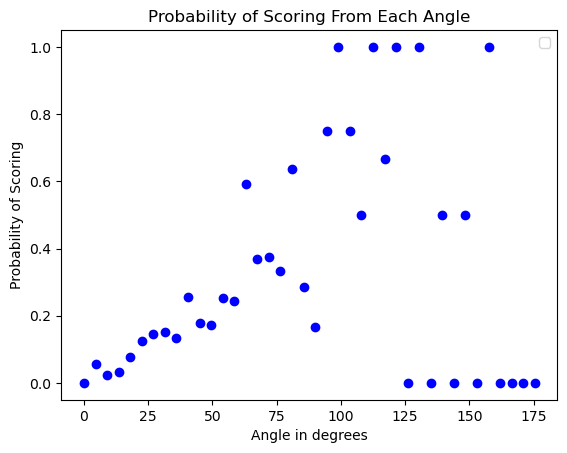

In [136]:
#Probability of scoring from an angle visual

# Define the number of bins and the range of angles
num_bins = 40
angle_range = (0, 180)  # Range of angles (in degrees)

# Extract the 'angle' and 'goal' columns
angles = shots_df['angle']
goals = shots_df['goal']

# Calculate the histogram for shots and goals
hist_shots, bin_edges = np.histogram(angles, bins=num_bins, range=angle_range)
hist_goals, _ = np.histogram(angles[goals == 1], bins=num_bins, range=angle_range)

# Convert the histograms to floats before division
hist_shots = hist_shots.astype(float)
hist_goals = hist_goals.astype(float)

# Calculate the probability of scoring from each angle
probabilities = np.divide(hist_goals, hist_shots, out=np.zeros_like(hist_goals), where=hist_shots != 0)



# Plot the probability distribution using a scatter plot
plt.scatter(bin_edges[:-1], probabilities, color='b')
plt.xlabel('Angle in degrees')
plt.ylabel('Probability of Scoring')
plt.title('Probability of Scoring From Each Angle')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


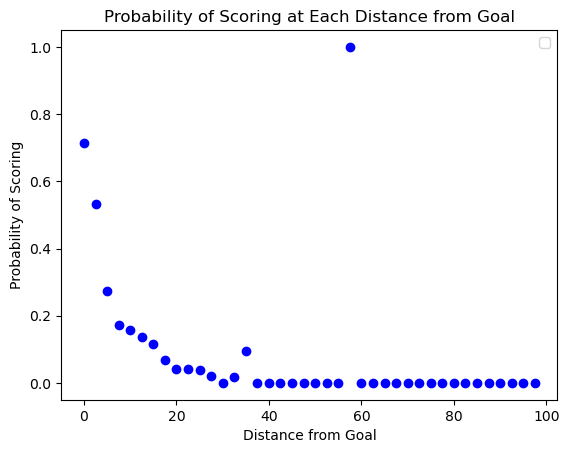

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins and the range of distances
num_bins = 40
distance_range = (0, 100)  # Range of distances

# Extract the 'distance' and 'goal' columns
distances = shots_df['distance']
goals = shots_df['goal']

# Calculate the histogram for shots and goals based on distance
hist_shots, bin_edges = np.histogram(distances, bins=num_bins, range=distance_range)
hist_goals, _ = np.histogram(distances[goals == 1], bins=num_bins, range=distance_range)

# Convert the histograms to floats before division
hist_shots = hist_shots.astype(float)
hist_goals = hist_goals.astype(float)

# Calculate the probability of scoring from each distance
probabilities = np.divide(hist_goals, hist_shots, out=np.zeros_like(hist_goals), where=hist_shots != 0)

# Plot the probability distribution using a scatter plot
plt.scatter(bin_edges[:-1], probabilities, color='b')
plt.xlabel('Distance from Goal')
plt.ylabel('Probability of Scoring')
plt.title('Probability of Scoring at Each Distance from Goal')
plt.legend()
plt.show()


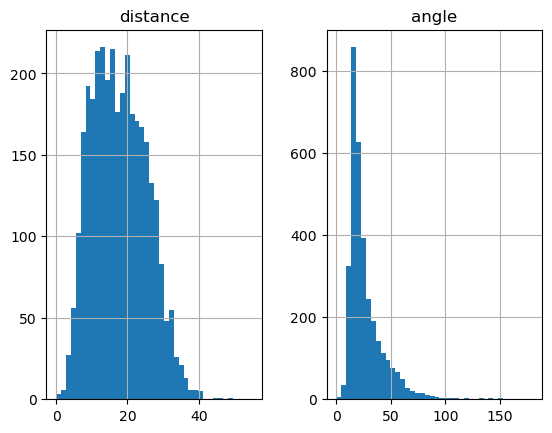

In [138]:
#plot distributions of shots by distance and angle side by side
fig, axes = plt.subplots(1, 2)
distance = shots_df.hist("distance",bins=40,range = (0,55),ax= axes[0])
angles = shots_df.hist("angle",bins=40, range = (0,180),ax=axes[1])

In [139]:
shots_df.columns

Index(['goalkeeper_position', 'id', 'index', 'location', 'match_id', 'minute',
       'play_pattern', 'player_id', 'shot_body_part', 'shot_deflected',
       'shot_end_location', 'shot_first_time', 'shot_freeze_frame',
       'shot_one_on_one', 'shot_open_goal', 'shot_outcome',
       'shot_statsbomb_xg', 'shot_technique', 'shot_type',
       'shot_follows_dribble', 'x_end', 'y_end', 'c_end', 'goal', 'x', 'y',
       'angle', 'distance'],
      dtype='object')

# Preprocessing columns for Modeling

While we already dropped a significant number of features in the data cleaning section. Through further exploration of the data we have isolated further columns with no value to our model.

In this section it is also important for all binary categorical columns to convert all NaN values to zeros and the existing label ones.

In [140]:
columns_to_drop3 = ['location', 'player_id', 'shot_end_location',
                    'id', 'index', 'match_id', 'shot_type', 'x_end', 'y_end', 'c_end',
                    'x', 'y', 'c', 'shot_outcome', 'shot_freeze_frame', 'shot_statsbomb_xg', 'goalkeeper_position']

In [141]:
#dropping unwanted columns
columns_to_drop_existing = [col for col in columns_to_drop3 if col in shots_df.columns]
shots_df.drop(columns=columns_to_drop_existing, inplace=True, errors='ignore')

In [142]:
#sanity check
shots_df.head()

,minute,play_pattern,shot_body_part,shot_deflected,shot_first_time,shot_one_on_one,shot_open_goal,shot_technique,shot_follows_dribble,goal,angle,distance
0,0,From Kick Off,Left Foot,NaN,True,NaN,NaN,Half Volley,NaN,0,18.879548,24.029981
1,0,From Kick Off,Left Foot,NaN,True,NaN,NaN,Half Volley,NaN,0,59.821068,6.935416
2,0,From Kick Off,Right Foot,NaN,True,NaN,NaN,Half Volley,NaN,0,27.397542,16.311039
3,4,From Corner,Head,NaN,NaN,NaN,NaN,Normal,NaN,0,48.565404,8.430896
4,10,Regular Play,Left Foot,NaN,NaN,NaN,NaN,Normal,NaN,0,16.255762,25.001800


In [143]:
# Replace NaN values with 0 in specific columns
shots_df['shot_open_goal'].fillna(0, inplace=True)

shots_df['shot_follows_dribble'].fillna(0, inplace=True)

shots_df['shot_one_on_one'].fillna(0, inplace=True)

shots_df['shot_deflected'].fillna(0, inplace=True)

shots_df['shot_first_time'].fillna(0, inplace=True)

In [144]:
#converting non-zeros to 1s
shots_df['shot_open_goal'] = shots_df['shot_open_goal'].apply(lambda x: 1 if (x != 0 and not pd.isna(x)) else x)

shots_df['shot_follows_dribble'] = shots_df['shot_follows_dribble'].apply(lambda x: 1 if (x != 0 and not pd.isna(x)) else x)

shots_df['shot_one_on_one'] = shots_df['shot_follows_dribble'].apply(lambda x: 1 if (x != 0 and not pd.isna(x)) else x)

shots_df['shot_deflected'] = shots_df['shot_follows_dribble'].apply(lambda x: 1 if (x != 0 and not pd.isna(x)) else x)

shots_df['shot_first_time'] = shots_df['shot_follows_dribble'].apply(lambda x: 1 if (x != 0 and not pd.isna(x)) else x)

In [145]:
#sanity check
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3348 entries, 0 to 3621
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   minute                3348 non-null   int64  
 1   play_pattern          3348 non-null   object 
 2   shot_body_part        3348 non-null   object 
 3   shot_deflected        3348 non-null   int64  
 4   shot_first_time       3348 non-null   int64  
 5   shot_one_on_one       3348 non-null   int64  
 6   shot_open_goal        3348 non-null   int64  
 7   shot_technique        3348 non-null   object 
 8   shot_follows_dribble  3348 non-null   int64  
 9   goal                  3348 non-null   int64  
 10  angle                 3348 non-null   float64
 11  distance              3348 non-null   float64
dtypes: float64(2), int64(7), object(3)
memory usage: 340.0+ KB


# Preprocessing: SMOTE

The data set we're using is very unbalanced. For that reason we are used SMOTE to provide synthetic data to balance it out. Additionally we're using pd.get_dummies to convert all of our categorical columns into a collection of numerical ones.

In [146]:
# Split the data into target and predictors
y = shots_df['goal']
X = shots_df.drop(columns=['goal'], axis=1)
X = pd.get_dummies(X)
X.head()

,minute,shot_deflected,shot_first_time,shot_one_on_one,shot_open_goal,shot_follows_dribble,angle,distance,play_pattern_From Corner,play_pattern_From Counter,...,shot_body_part_Left Foot,shot_body_part_Other,shot_body_part_Right Foot,shot_technique_Backheel,shot_technique_Diving Header,shot_technique_Half Volley,shot_technique_Lob,shot_technique_Normal,shot_technique_Overhead Kick,shot_technique_Volley
0,0,0,0,0,0,0,18.879548,24.029981,0,0,...,1,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,59.821068,6.935416,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,27.397542,16.311039,0,0,...,0,0,1,0,0,1,0,0,0,0
3,4,0,0,0,0,0,48.565404,8.430896,1,0,...,0,0,0,0,0,0,0,1,0,0
4,10,0,0,0,0,0,16.255762,25.001800,0,0,...,1,0,0,0,0,0,0,1,0,0


In [147]:
shots_df['goal'].value_counts()

0    2979
1     369
Name: goal, dtype: int64

In [148]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [149]:
# Step 2: Instantiate the StandardScaler
scaler = StandardScaler()

# Step 3: Fit the StandardScaler
scaler.fit(X_train)

# Step 4: Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.columns)

In [150]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    2979
1     369
Name: goal, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    2233
0    2233
Name: goal, dtype: int64


# Logistic Regression Model

Before we run the model it is important to have a sense of which metric will be used to determine its effectiveness. Expected Goals (xG) is not as valuable or effective when predicting a single shot, and it better used as a tool to measure attacking and defending strength of a larger sample of shots. Additionally, failing to classify a goal as a goal or miss as a miss are equally bad. For this reason, as we want to generally maximize the ability for our model to classify shots, we are targeting ROC AUC as our metric of choice.

The ROC curve plots the model’s ability to predict misses correctly versus its ability to incorrectly predict goals for different threshold values. As you move up the y-axis, the model better predicts misses, and as we move to the left along the x-axis, the model better predicts goals. The further away our ROC curve is from the 45 degree line, the better overall job it does at classifying the test data. This is useful because we can use it to compare different models and to see which changes to the model may improve the ROC curve.

Additionally, a Decision Tree classifier doesn't make a ton of sense for this problem. As previously mentioned, single sample prediction is not what xG is focused on and the probabilistic outputs that Logistic Regression uses are essentially what an xG value is. 

In [151]:
# Instantiate the model
logregSMOTE = LogisticRegression()

# Fit the model
logregSMOTE.fit(X_train_resampled, y_train_resampled)

LogisticRegression()

In [152]:
# Generate predictions
y_hat_train = logregSMOTE.predict(X_train_resampled)
y_hat_test = logregSMOTE.predict(X_test_scaled)

In [153]:
probabilities = logregSMOTE.predict_proba(X_test_scaled)
probabilities

array([[7.45153820e-01, 2.54846180e-01],
       [8.89686602e-01, 1.10313398e-01],
       [3.59881801e-01, 6.40118199e-01],
       ...,
       [9.99630653e-01, 3.69346502e-04],
       [8.12547204e-01, 1.87452796e-01],
       [5.88188223e-01, 4.11811777e-01]])

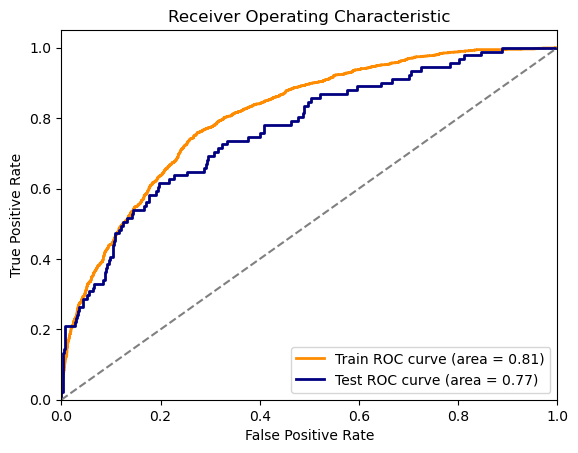

In [154]:
# Predict probabilities for the training and testing data
y_train_prob = logregSMOTE.predict_proba(X_train_resampled)[:, 1]
y_test_prob = logregSMOTE.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_train_prob)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve for testing data
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='navy', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Model Evaluation

In [155]:
# Predictions on the test set
predictions = logregSMOTE.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


Accuracy: 0.7323775388291517
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       746
           1       0.24      0.65      0.35        91

    accuracy                           0.73       837
   macro avg       0.59      0.70      0.59       837
weighted avg       0.87      0.73      0.78       837

Confusion Matrix:
[[554 192]
 [ 32  59]]


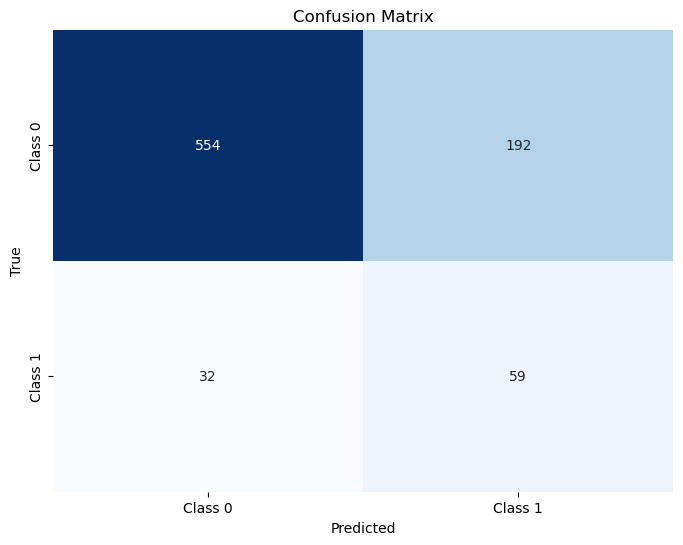

In [156]:
cf = confusion_matrix(y_test, predictions)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model Tuning and Optimization

In order to try and maximize ROC AUC, we will test out a series of parameters to see which improves our model the most.

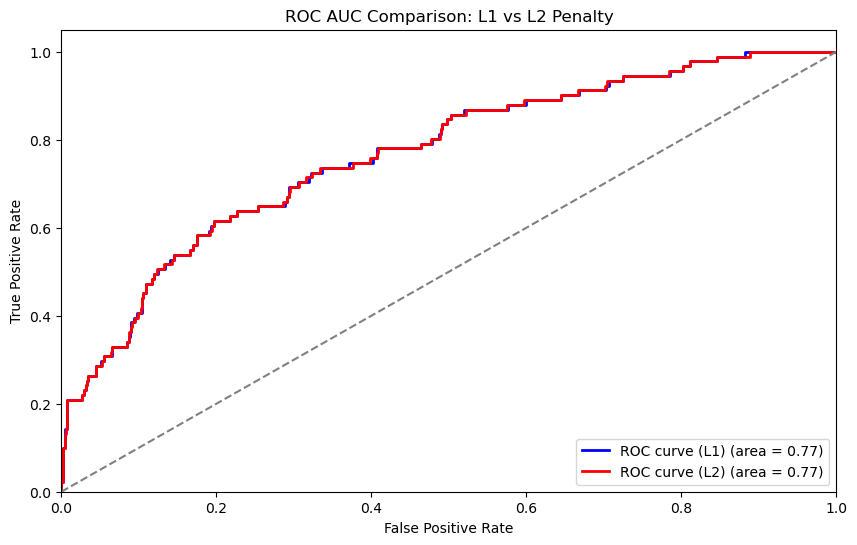

In [157]:
# Create logistic regression models with L1 and L2 penalties
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Train the models
model_l1.fit(X_train_resampled, y_train_resampled)
model_l2.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for test set
y_prob_l1 = model_l1.predict_proba(X_test_scaled)[:, 1]
y_prob_l2 = model_l2.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curves and AUC values
fpr_l1, tpr_l1, _ = roc_curve(y_test, y_prob_l1)
roc_auc_l1 = auc(fpr_l1, tpr_l1)

fpr_l2, tpr_l2, _ = roc_curve(y_test, y_prob_l2)
roc_auc_l2 = auc(fpr_l2, tpr_l2)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_l1, tpr_l1, color='blue', lw=2, label=f'ROC curve (L1) (area = {roc_auc_l1:.2f})')
plt.plot(fpr_l2, tpr_l2, color='red', lw=2, label=f'ROC curve (L2) (area = {roc_auc_l2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Comparison: L1 vs L2 Penalty')
plt.legend(loc="lower right")
plt.show()

In [158]:
# Assuming 'model' is your logistic regression model
y_probabilities = logregSMOTE.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)


# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal Threshold:', optimal_threshold)

Optimal Threshold: 0.5527878133059674


It is important to remember that for each of these models the Logistic Regression is predicting the majority class which is misses. This means that a True Positive is a miss that is predicted as such.



LogisticRegression(C=0.001, fit_intercept=False, solver='liblinear')
AUC for 0.001: 0.7624105117402704
-------------------------------------------------------
LogisticRegression(C=0.01, fit_intercept=False, solver='liblinear')
AUC for 0.01: 0.7676987891465104
-------------------------------------------------------
LogisticRegression(C=0.1, fit_intercept=False, solver='liblinear')
AUC for 0.1: 0.7678902866570426
-------------------------------------------------------
LogisticRegression(C=1, fit_intercept=False, solver='liblinear')
AUC for 1: 0.7677724420351766
-------------------------------------------------------
LogisticRegression(C=10, fit_intercept=False, solver='liblinear')
AUC for 10: 0.7677135197242435
-------------------------------------------------------
LogisticRegression(C=100, fit_intercept=False, solver='liblinear')
AUC for 100: 0.7676840585687771
-------------------------------------------------------


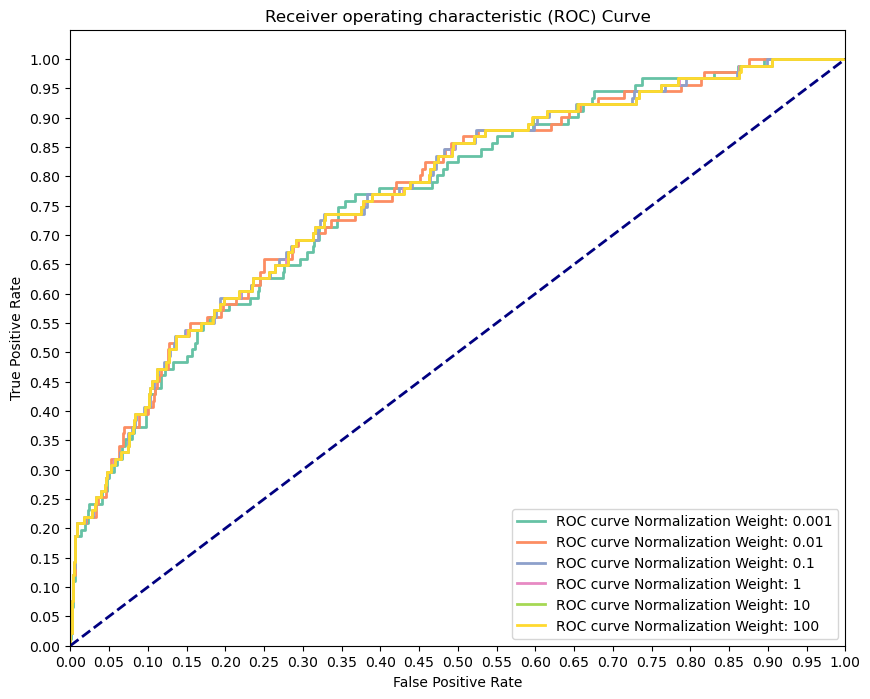

In [159]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test_scaled)

    y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test_scaled)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Setting the C parameter to .001 or .01 are improvements from the baseline model. The success of smaller C values means that the model is better when it is simpler. Lets see if we can do even better.

In [160]:
# Define the range of C values to search
param_grid = {'C': [0.003, 0.005, 0.007, 0.01, 0.03, 0.05]}

# Create a Logistic Regression model
log_reg_model_C = LogisticRegression()

# Perform a grid search over the C values
grid_search = GridSearchCV(log_reg_model_C, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best C value
best_C = grid_search.best_params_['C']
print("Best C value:", best_C)


Best C value: 0.03


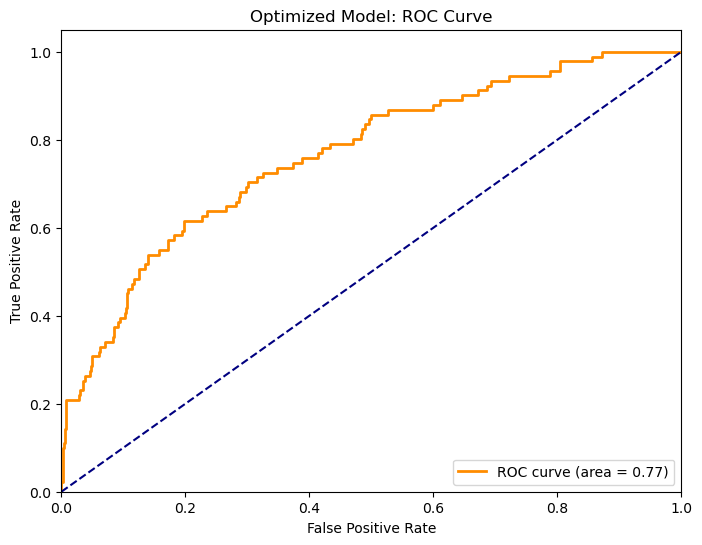

In [161]:
# Train the Logistic Regression model with C=0.03
log_reg_model_OPT = LogisticRegression(C=0.03, random_state=42)
log_reg_model_OPT.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for the test set
y_proba = log_reg_model_OPT.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Model: ROC Curve')
plt.legend(loc="lower right")
plt.show()

Following our parameter tuning, we found that none of the tactics we employed made a significant difference on the ROC AUC output of our models. 

In [162]:
#Access the coefficients for each feature
coefficients = log_reg_model_OPT.coef_

# Print the coefficients for each feature
print("Coefficients for each feature:")
for feature, coef in zip(X_train_resampled.columns, coefficients[0]):
    print(f"{feature}: {coef}")

Coefficients for each feature:
minute: 0.10057208026152864
shot_deflected: -0.028482006183379396
shot_first_time: -0.028482006183379396
shot_one_on_one: -0.028482006183379396
shot_open_goal: 0.1242835771762169
shot_follows_dribble: -0.028482006183379396
angle: 0.6894153143714251
distance: -0.8084305291043526
play_pattern_From Corner: -0.2548833441452644
play_pattern_From Counter: 0.02907350579791304
play_pattern_From Free Kick: 0.09170438760415747
play_pattern_From Goal Kick: 0.010779789156507581
play_pattern_From Keeper: 0.07220489487818153
play_pattern_From Kick Off: -0.05094224527948929
play_pattern_From Throw In: -0.0365754300155574
play_pattern_Other: -0.05634469336851258
play_pattern_Regular Play: 0.14213476089374324
shot_body_part_Head: -0.45356509422981345
shot_body_part_Left Foot: 0.27398170080836853
shot_body_part_Other: -0.18150970429475782
shot_body_part_Right Foot: 0.11524710547455448
shot_technique_Backheel: -0.08823422671667629
shot_technique_Diving Header: 0.09534390917

The Coefficients for each feature tell us which features are most impacting the predictions, based on a single unit change. It is important to remember that a positive value means contributing to a miss, whereas a negative value means it is detracting from a miss (ie. contributing to a goal). Due to the fact that not every feature uses the same units, it is important to only compared within categories. Considering this we can see that in the category play_pattern the feature most likely to contribute to a goal is From Corner. We can also see that headers and shots using 'Other' body parts are most likely to contribute to scoring goals. Angle and Distance have the highest coefficients and for good reason, it makes sense that distance and location matter more than the pattern of play or shot technique used.

# Real World Application

While AFC Richmond is a fictional team, it is reasonable to believe that if we applied this Logistic Regression model to their shot data from a previous season, and compared it to the rest of the league, we could get very solid predictions as to the strength of their attack and defense in comparison to their opponents. This is valuable because standard datapoints such as goals scored/conceded and shots taken/conceded are not as good predictors of future goals as expected goal are. Richmond could potentially be gaining an advantage on their competitors by being able to more accurately diagnose the areas they need to improve. For the same reason, Richmond would be better equiped to evaluate  players to buy. They would know that a striker who scored 10 goals on 15xG worth of shots would be more likely to outproduce a striker who scored 10 goals on 5xG worth of shots.